In [13]:
import pandas as pd
import scanpy as sc
import sys
import numpy as np
import scipy
import joblib
import matplotlib.pyplot as plt
from utils import hypergeometric_test, adjust_p_value_fdr, get_overlapping_met_genes

In [2]:
out_file_path = './'
data_dir = out_file_path + 'data/'
gene_signature_dir = out_file_path + 'gene_signatures/'
out_dir = out_file_path + 'compass_hypergeom_results/'

From DESeq2, look for enrichment of metabolism terms in DE genes

**read gene signatures**

In [3]:
out_filename = gene_signature_dir + 'metabolism_rxn_subsystem.pickle'
subsystem_to_genes = joblib.load(out_filename)
metabolism_sig = {key: [item[0] for item in subsystem_to_genes[key]] for key in subsystem_to_genes}

In [4]:
for k,v in metabolism_sig.items():
    print(f'{k}: {len(v)}')

Fatty acid oxidation: 32
Nucleotide interconversion: 102
Keratan sulfate degradation: 11
Sphingolipid metabolism: 29
Tyrosine metabolism: 34
Keratan sulfate synthesis: 15
Steroid metabolism: 25
Chondroitin synthesis: 30
Tryptophan metabolism: 36
Glycerophospholipid metabolism: 61
Inositol phosphate metabolism: 60
Folate metabolism: 11
Valine, leucine, and isoleucine metabolism: 31
Chondroitin sulfate degradation: 10
Cholesterol metabolism: 22
Arginine and Proline Metabolism: 33
Bile acid synthesis: 9
Fatty acid synthesis: 8
Glycine, serine, alanine and threonine metabolism: 23
Pyrimidine catabolism: 23
Blood group synthesis: 5
Pyruvate metabolism: 32
Aminosugar metabolism: 26
Heparan sulfate degradation: 6
Urea cycle: 17
Purine catabolism: 13
Eicosanoid metabolism: 19
Methionine and cysteine metabolism: 20
Lysine metabolism: 25
Starch and sucrose metabolism: 14
Pentose phosphate pathway: 12
NAD metabolism: 14
Vitamin A metabolism: 15
beta-Alanine metabolism: 21
Triacylglycerol synthesi

In [5]:
# read in DE genes
compass_data = pd.read_csv(data_dir + 'th_data/GSE162300_DFMO_RNA_est_counts.csv', sep = ',', index_col = 0) # this is library size normalized already
samples = list(set([i[:-9] for i in compass_data.columns]))

In [6]:
n_genes_total = len(compass_data.index)
n_genes_total

20817

In [165]:
# these are for thP vs N

In [7]:
de_genes_th_1 = pd.read_csv(data_dir + 'th_data/deseq_genes_th_uncollapse.csv', index_col = 0)
de_genes_th_2 = pd.read_csv(data_dir + 'th_data/deseq_genes_th_collapse.csv', index_col = 0)

# for DE genes of Th17p vs Th17n

In [15]:
logfc_thresh = 0
p_thresh = 0.05

In [16]:
de_genes_th_1

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0610007P14RIK,944.099532,-0.145766,0.050880,-2.864867,4.171846e-03,1.344874e-02
0610009B22RIK,86.186921,0.244914,0.142373,1.720221,8.539226e-02,1.719417e-01
0610009L18RIK,3.371014,-0.814473,0.686218,-1.186901,2.352666e-01,3.753754e-01
0610009O20RIK,195.335549,-0.110608,0.093428,-1.183884,2.364589e-01,3.767663e-01
0610010F05RIK,25.537423,-0.075539,0.247169,-0.305619,7.598948e-01,8.430450e-01
...,...,...,...,...,...,...
ZYG11A,0.000000,NaN,NaN,NaN,NaN,NaN
ZYG11B,288.482467,0.080973,0.090098,0.898727,3.687982e-01,5.198402e-01
ZYX,398.640411,-0.455847,0.070043,-6.508119,7.609765e-11,8.329504e-10
ZZEF1,212.350099,0.151869,0.107047,1.418710,1.559836e-01,2.755397e-01


In [17]:
M = n_genes_total
hypergeom_res_th_1 = {k: {} for k in ['pvn', 'nvp']}
for key in ['pvn', 'nvp']:
    df = de_genes_th_1.copy()
    df = df[df['padj'] < p_thresh]
    if key == 'pvn':
        df = df[df['log2FoldChange'] > logfc_thresh]
    else:
        df = df[df['log2FoldChange'] < logfc_thresh]
    print(f'{key}: {len(df)}')
    df['genes'] = df.index.str.upper()
    df_genes = set(df['genes'])
    N = len(df) # length of DE genes
    for k,v in metabolism_sig.items():
        n = len(v) # number of met genes
        x = len(df_genes.intersection(v))
        pct_overlap = x/(N+n)

        if pct_overlap > 0:
            p_val = hypergeometric_test(total_genes_expressed=M, n_genes_of_interest=n, 
                                        n_genes_picked=N, n_overlap=x)
            hypergeom_res_th_1[key][k] = p_val
        else:
            hypergeom_res_th_1[key][k] = 1

pvn: 2443
nvp: 2476


In [18]:
hypergeom_df_th = pd.DataFrame.from_dict(hypergeom_res_th_1)
hypergeom_df_th['term'] = hypergeom_df_th.index
hypergeom_res_th_1hypergeom_df_th = hypergeom_df_th.melt('term')
hypergeom_df_th['padj_pvn'] = adjust_p_value_fdr(hypergeom_df_th['pvn'])
hypergeom_df_th['padj_nvp'] = adjust_p_value_fdr(hypergeom_df_th['nvp'])
hypergeom_df_th

,pvn,nvp,term,padj_pvn,padj_nvp
Fatty acid oxidation,0.742000,0.538351,Fatty acid oxidation,1.000000,1.000000
Nucleotide interconversion,0.003273,0.326004,Nucleotide interconversion,0.132538,0.528126
Keratan sulfate degradation,0.129888,0.033090,Keratan sulfate degradation,0.553733,0.178687
Sphingolipid metabolism,0.677954,0.122499,Sphingolipid metabolism,1.000000,1.000000
Tyrosine metabolism,0.368829,0.786827,Tyrosine metabolism,0.963715,1.000000
...,...,...,...,...,...
"Transport, lysosomal",0.010499,0.938418,"Transport, lysosomal",0.014920,1.000000
Vitamin B12 metabolism,1.000000,1.000000,Vitamin B12 metabolism,1.000000,1.000000
N-glycan synthesis,0.393088,0.072004,N-glycan synthesis,0.692177,0.112160
D-alanine metabolism,1.000000,1.000000,D-alanine metabolism,1.000000,1.000000


In [19]:
print(f"pvn: {len(hypergeom_df_th[hypergeom_df_th['padj_pvn'] < 0.05])}\nnvp: {len(hypergeom_df_th[hypergeom_df_th['padj_nvp'] < 0.05])}")
      

pvn: 7
nvp: 5


In [20]:
th_results_pvn = hypergeom_df_th[hypergeom_df_th['padj_pvn'] < 0.05].sort_values('padj_pvn')
th_results_pvn

,pvn,nvp,term,padj_pvn,padj_nvp
"Glycine, serine, alanine and threonine metabolism",0.003426,0.777104,"Glycine, serine, alanine and threonine metabolism",0.005663,1.000000
"Valine, leucine, and isoleucine metabolism",0.002096,0.067684,"Valine, leucine, and isoleucine metabolism",0.005855,0.342649
"Transport, lysosomal",0.010499,0.938418,"Transport, lysosomal",0.014920,1.000000
Pentose phosphate pathway,0.008620,0.781288,Pentose phosphate pathway,0.030359,1.000000
Methionine and cysteine metabolism,0.023489,0.430961,Methionine and cysteine metabolism,0.030687,0.537044
Purine synthesis,0.005890,1.000000,Purine synthesis,0.031808,1.000000
Urea cycle,0.040957,0.883935,Urea cycle,0.046725,1.000000


In [21]:
th_results_nvp = hypergeom_df_th[hypergeom_df_th['padj_nvp'] < 0.05].sort_values('padj_nvp')
th_results_nvp

,pvn,nvp,term,padj_pvn,padj_nvp
Inositol phosphate metabolism,0.847815,0.000454,Inositol phosphate metabolism,1.000000,0.000491
Cholesterol metabolism,0.748311,0.002710,Cholesterol metabolism,0.841850,0.002889
Heme synthesis,0.527206,0.002455,Heme synthesis,1.000000,0.004970
Aminosugar metabolism,0.364694,0.008583,Aminosugar metabolism,0.671368,0.025748
Keratan sulfate synthesis,0.254237,0.005421,Keratan sulfate synthesis,0.267444,0.031362


In [22]:
th_results_pvn.to_csv(out_dir + 'hypergeom_th_results_Th17p_v_Th17n_compass.csv')
th_results_nvp.to_csv(out_dir + 'hypergeom_th_results_Th17n_v_Th17p_compass.csv')

## remove non-overlapping genes

In [38]:
all_genes = list(compass_data.index)
overlapping_terms, n_removed_terms = get_overlapping_met_genes(metabolism_sig, all_genes, verb = True)

Fatty acid oxidation	original: 32 | overlapping: 32 | removed: 0
Nucleotide interconversion	original: 102 | overlapping: 101 | removed: 1
Keratan sulfate degradation	original: 11 | overlapping: 11 | removed: 0
Sphingolipid metabolism	original: 29 | overlapping: 29 | removed: 0
Tyrosine metabolism	original: 34 | overlapping: 33 | removed: 1
Keratan sulfate synthesis	original: 15 | overlapping: 14 | removed: 1
Steroid metabolism	original: 25 | overlapping: 24 | removed: 1
Chondroitin synthesis	original: 30 | overlapping: 30 | removed: 0
Tryptophan metabolism	original: 36 | overlapping: 35 | removed: 1
Glycerophospholipid metabolism	original: 61 | overlapping: 59 | removed: 2
Inositol phosphate metabolism	original: 60 | overlapping: 60 | removed: 0
Folate metabolism	original: 11 | overlapping: 10 | removed: 1
Valine, leucine, and isoleucine metabolism	original: 31 | overlapping: 31 | removed: 0
Chondroitin sulfate degradation	original: 10 | overlapping: 10 | removed: 0
Cholesterol metabol

(array([ 2.,  0.,  0.,  0.,  1.,  1.,  3.,  4.,  8., 62.]),
 array([0.79166667, 0.8125    , 0.83333333, 0.85416667, 0.875     ,
        0.89583333, 0.91666667, 0.9375    , 0.95833333, 0.97916667,
        1.        ]),
 <BarContainer object of 10 artists>)

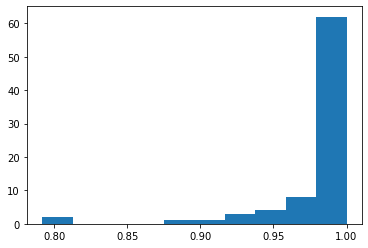

In [36]:
prop_removed = {}
for k,v in n_removed_terms.items():
    prop_removed[k] = (len(metabolism_sig[k]) - v)/len(metabolism_sig[k])
plt.hist(prop_removed.values())

(array([61.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.]),
 array([0.   , 0.175, 0.35 , 0.525, 0.7  , 0.875, 1.05 , 1.225, 1.4  ,
        1.575, 1.75 , 1.925, 2.1  , 2.275, 2.45 , 2.625, 2.8  , 2.975,
        3.15 , 3.325, 3.5  , 3.675, 3.85 , 4.025, 4.2  , 4.375, 4.55 ,
        4.725, 4.9  , 5.075, 5.25 , 5.425, 5.6  , 5.775, 5.95 , 6.125,
        6.3  , 6.475, 6.65 , 6.825, 7.   ]),
 <BarContainer object of 40 artists>)

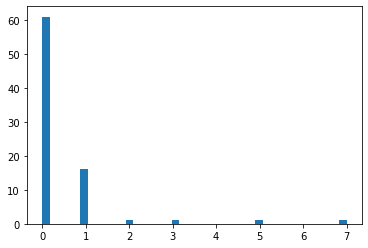

In [37]:
plt.hist(n_removed_terms.values(), bins = 40)

In [32]:
# remove keys without genes
for k in [k for k,v in overlapping_terms.items() if len(v) == 0]:
    print(k)
    overlapping_terms.pop(k)

In [42]:
M = n_genes_total
hypergeom_res_th_overlap = {k: {} for k in ['pvn', 'nvp']}
for key in ['pvn', 'nvp']:
    df = de_genes_th_1.copy()
    df = df[df['padj'] < p_thresh]
    if key == 'pvn':
        df = df[df['log2FoldChange'] > logfc_thresh]
    else:
        df = df[df['log2FoldChange'] < logfc_thresh]
    print(f'{key}: {len(df)}')
    df['genes'] = df.index.str.upper()
    df_genes = set(df['genes'])
    N = len(df) # length of DE genes
    for k,v in overlapping_terms.items():
        n = len(v) # number of met genes
        x = len(df_genes.intersection(v))
        pct_overlap = x/(N+n)

        if pct_overlap > 0:
            p_val = hypergeometric_test(total_genes_expressed=M, n_genes_of_interest=n, 
                                        n_genes_picked=N, n_overlap=x)
            hypergeom_res_th_overlap[key][k] = p_val
        else:
            hypergeom_res_th_overlap[key][k] = 1

pvn: 2443
nvp: 2476


In [43]:
hypergeom_df_th_overlap = pd.DataFrame.from_dict(hypergeom_res_th_overlap)
hypergeom_df_th_overlap['term'] = hypergeom_df_th_overlap.index
hypergeom_res_th_overlaphypergeom_df_th_overlap = hypergeom_df_th_overlap.melt('term')
hypergeom_df_th_overlap['padj_pvn'] = adjust_p_value_fdr(hypergeom_df_th_overlap['pvn'])
hypergeom_df_th_overlap['padj_nvp'] = adjust_p_value_fdr(hypergeom_df_th_overlap['nvp'])
hypergeom_df_th_overlap

,pvn,nvp,term,padj_pvn,padj_nvp
Fatty acid oxidation,0.742000,0.538351,Fatty acid oxidation,1.000000,1.000000
Nucleotide interconversion,0.002879,0.312586,Nucleotide interconversion,0.116604,1.000000
Keratan sulfate degradation,0.129888,0.033090,Keratan sulfate degradation,0.553733,0.053606
Sphingolipid metabolism,0.677954,0.122499,Sphingolipid metabolism,1.000000,1.000000
Tyrosine metabolism,0.344419,0.769291,Tyrosine metabolism,0.899933,1.000000
...,...,...,...,...,...
"Transport, lysosomal",0.010499,0.938418,"Transport, lysosomal",0.013288,1.000000
Vitamin B12 metabolism,1.000000,1.000000,Vitamin B12 metabolism,1.000000,1.000000
N-glycan synthesis,0.393088,0.072004,N-glycan synthesis,0.398002,0.112160
D-alanine metabolism,1.000000,1.000000,D-alanine metabolism,1.000000,1.000000


In [45]:
print(f"pvn: {len(hypergeom_df_th_overlap[hypergeom_df_th_overlap['padj_pvn'] < 0.05])}\nnvp: {len(hypergeom_df_th_overlap[hypergeom_df_th_overlap['padj_nvp'] < 0.05])}")

pvn: 8
nvp: 6


In [46]:
th_results_overlap_pvn = hypergeom_df_th_overlap[hypergeom_df_th_overlap['padj_pvn'] < 0.05].sort_values('padj_pvn')
th_results_overlap_pvn

,pvn,nvp,term,padj_pvn,padj_nvp
"Glycine, serine, alanine and threonine metabolism",0.003426,0.777104,"Glycine, serine, alanine and threonine metabolism",0.005663,1.000000
"Valine, leucine, and isoleucine metabolism",0.002096,0.067684,"Valine, leucine, and isoleucine metabolism",0.009432,0.342649
"Transport, lysosomal",0.010499,0.938418,"Transport, lysosomal",0.013288,1.000000
Methionine and cysteine metabolism,0.018209,0.397519,Methionine and cysteine metabolism,0.023789,0.495370
Purine synthesis,0.005890,1.000000,Purine synthesis,0.031808,1.000000
Selenoamino acid metabolism,0.024223,0.547394,Selenoamino acid metabolism,0.038472,0.943381
Glutamate metabolism,0.031660,0.382890,Glutamate metabolism,0.040705,0.646126
Urea cycle,0.040957,0.883935,Urea cycle,0.046725,1.000000


In [47]:
th_results_overlap_nvp = hypergeom_df_th_overlap[hypergeom_df_th_overlap['padj_nvp'] < 0.05].sort_values('padj_nvp')
th_results_overlap_nvp

,pvn,nvp,term,padj_pvn,padj_nvp
Inositol phosphate metabolism,0.847815,0.000454,Inositol phosphate metabolism,1.000000,0.000466
Heme synthesis,0.527206,0.002455,Heme synthesis,0.736271,0.004970
Cholesterol metabolism,0.724483,0.001923,Cholesterol metabolism,0.815044,0.007418
Aminosugar metabolism,0.364694,0.008583,Aminosugar metabolism,0.671368,0.012414
Keratan sulfate synthesis,0.221345,0.003612,Keratan sulfate synthesis,0.232844,0.020901
N-glycan degradation,0.527206,0.025456,N-glycan degradation,0.805730,0.032729


In [48]:
th_results_overlap_pvn.to_csv(out_dir + 'hypergeom_th_results_overlap_Th17p_v_Th17n_compass.csv')
th_results_overlap_nvp.to_csv(out_dir + 'hypergeom_th_results_overlap_Th17n_v_Th17p_compass.csv')